# Image Processing Project : Recharge cell phone Cards


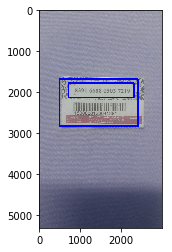

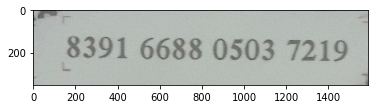

C:\Users\Amany\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


card number:  [8, 3, 9, 1, 6, 6, 8, 8, 0, 5, 0, 3, 2, 7, 1, 9]
Numbers detected [0, 1, 2, 3, 5, 6, 7, 8, 9]


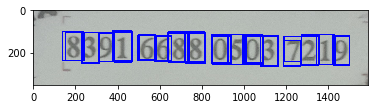

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils
from imutils import contours

im = cv2.imread("card_scanned_by_camera.png",1)
im_c = im.copy()
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ima = cv2.imread("card_template.png",0)
ima = cv2.Canny(ima, 50, 200)
(tH, tW) = ima.shape[:2]

#check for all scales of image to get best matching
found = None
for scale in np.linspace(0.2, 1.0, 20)[::-1]:
	# resize the image according to the scale, and keep track
	# of the ratio of the resizing
	resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
	r = gray.shape[1] / float(resized.shape[1])
 
	# if the resized image is smaller than the template, then break
	# from the loop
	if resized.shape[0] < tH or resized.shape[1] < tW:
		break

	# detect edges in the resized, grayscale image and apply template
	# matching to find the template in the image
	edged = cv2.Canny(resized, 50, 200)
	result = cv2.matchTemplate(edged, ima, cv2.TM_CCOEFF_NORMED)
	(_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
 
 
	# if we have found a new maximum correlation value, then ipdate
	# the bookkeeping variable
	if found is None or maxVal > found[0]:
		found = (maxVal, maxLoc, r)
 
 # unpack the bookkeeping varaible and compute the (x, y) coordinates
# of the bounding box based on the resized ratio
(_, maxLoc, r) = found
(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
 
# draw a bounding box around the detected result
cv2.rectangle(im, (startX, startY), (endX, endY), (0, 0, 255), 40)
cv2.rectangle(im, (int(startX+0.1155*(endX-startX)), int(startY+0.0873*(endY-startY))), 
              (int(startX+0.95*(endX-startX)),int(startY+0.3954*(endY-startY))), (0, 0, 255), 40)


#scale of the number of the card 
x = int(startX+0.1155*(endX-startX))
xE = int(startX+0.95*(endX-startX))
y = int(startY+0.0873*(endY-startY))
yE = int(startY+0.3954*(endY-startY))

#the numbers on the card are croped
num = im_c[y:yE,x:xE]

plt.imshow(im)
plt.show()
plt.imshow(num)
plt.show()


#try to detect numbers on the cropped image
image = num.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
output=[]              #for the final number of card
numbers_detected=[]    #for the detected numbers on the card
dic_x ={}              #contains the x position for each number detected and the value of matching in "res" 
                       #to get the best matching for each detection

real_val =[]           #the values that have highest value in res so they are the real one

#loop on numbers templates 0->9 to detect each number on the card
for temp in range(0,10):
    t = cv2.imread(str(temp)+".png",0)     #the numbers 0->9 templates
    t = cv2.Canny(t, 50, 200)
    (tH, tW) = t.shape[:2]
    
    #loop for variable scale
    found = None
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        # resize the image according to the scale, and keep track
        # of the ratio of the resizing
        resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])

        # if the resized image is smaller than the template, then break
        # from the loop
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break

        # detect edges in the resized, grayscale image and apply template
        # matching to find the template in the image
        edged = cv2.Canny(resized, 50, 200)
        result = cv2.matchTemplate(edged, t, cv2.TM_CCOEFF_NORMED)
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)


        # if we have found a new maximum correlation value, then ipdate
        # the bookkeeping variable
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)        
            res = result

    #threshold the res values because the best match >0.3
    if found[0] > 0.3:
        (_, maxLoc, r) = found
        (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
        (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
        # draw a bounding box around the detected result 
        cv2.rectangle(image, (startX+2, startY), (endX, endY), (0, 0, 255), 5)
    
    #try to improve the detection by choosing the highest values in matches
    maxi=np.amax(res)
    res[found[1][1],found[1][0]]=0
    
    matches_loc = np.where( (res > 0.3))
    no_repeated=[]

    #make sure if number is not found so it doesnot match 
    if matches_loc[1] != []:
        maxi= res[matches_loc[0][0]][matches_loc[1][0]]      #max value in matches detected
        maxi_l= [matches_loc[1][0],matches_loc[0][0]]       #max location in matches detected
        
        
        #here i am trying to select matches that are meaningful (if multiple matches in same place choose only one)
        numbers_detected.append(temp)    
        for i in range(0,len(matches_loc[1])):
            if i < len(matches_loc[1])-1:
                if abs(matches_loc[1][i]-matches_loc[1][i+1]) < tW-9:
                    if res[matches_loc[0][i+1]][matches_loc[1][i+1]] > maxi:
                        maxi= res[matches_loc[0][i+1]][matches_loc[1][i+1]] 
                        maxi_l = [matches_loc[1][i+1],matches_loc[0][i+1]]

                else:
                    if maxi_l[0] != found[1][0]:
                        no_repeated.append(maxi_l)
                    maxi= res[matches_loc[0][i+1]][matches_loc[1][i+1]]
                    maxi_l = [matches_loc[1][i+1],matches_loc[0][i+1]]
                    if i == len(matches_loc[1])-2 and matches_loc[1][i+1] != found[1][0]:
                        no_repeated.append([matches_loc[1][i+1],matches_loc[0][i+1]])
            else:
                no_repeated.append([matches_loc[1][i],matches_loc[0][i]])
        

        dic_x[temp]=[(found[1][0],found[0])]
        for (x,y) in no_repeated:
            (startX, startY) = (int(x * r), int(y * r))
            (endX, endY) = (int((x + tW) * r), int((y + tH) * r))
            cv2.rectangle(image, (startX+5, startY), (endX, endY), (0, 0, 255), 5) 
            dic_x[temp].append((x,res[y][x]))
            

#here i try to extract the output from previous matches  
dict_x= dic_x.copy()

#sort and get the real values that not repeated and with highest match
for i in numbers_detected:
    dict_x[i].sort(key=lambda x:x[0])
    
    for j in range (0,len(dict_x[i])):
        if len(dict_x[i]) == 1 or j == len(dict_x[i])-1:
            real_val.append((i,dict_x[i][j]))
        elif abs(dict_x[i][j][0]-dict_x[i][j+1][0])>5:
            real_val.append((i,dict_x[i][j]))
                    

#sort to check if the detected value belongs to that number or another number
real_val.sort(key=lambda x:x[1])

maximum = real_val[0][0]
max_idx = 0
flag=0
for k in range(0,len(real_val)):
    if k < len(real_val)-1:
        if real_val[k+1][1][0] - real_val[k][1][0] <= 5:
            if  abs(real_val[k+1][1][1] - real_val[max_idx][1][1]) <0.05  :
                flag=1
            if real_val[k+1][1][1] > real_val[max_idx][1][1]:
                maximum = real_val[k+1][0]
                max_idx = k+1    
        else:
            output.append(maximum)
            if flag:
                output.append(real_val[k][0])
                flag=0
            maximum = real_val[k+1][0]
            max_idx = k+1      
    else:
        output.append(maximum)
        
print("card number: " ,output)   
print("Numbers detected" ,numbers_detected)
plt.imshow(image)
plt.show()
        
